# ECommerce_GloVe_LSTM_Supervised

In [1]:
import gensim
import nltk
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
    # Disable first GPU
    tf.config.set_visible_devices(physical_devices[1:], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    # Logical device was not created for first GPU
    assert len(logical_devices) == len(physical_devices) - 1
    print(f'{logical_devices=}')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import os

import warnings 
## warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

logical_devices=[]


## Data Loading and Exploratory Data Analysis

In [2]:
## Read the data set from a CSV file
## There is no header row in the input file.
## The first column is the label or Product_Category, and the 2nd column is
## the product and description as a string.
df = pd.read_csv('./data/ecommerceDataset.csv',header=None)

df.columns=['product_category','raw_text']
df

,product_category,raw_text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...
...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou..."


In [3]:
## Count the occurences of each product category
df['product_category'].value_counts()

Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: product_category, dtype: int64

## Data Cleaning

The data has no missing values, but the product descriptions are free-form text. We plan to use the GloVe pre-trained word
vectors to encode all the words we can match from the product descriptions. But the first steps are to convert all the text to lower case, remove all punctuation and non-alphabetic characters, and remove English stop words.

In [4]:
match_non_alpha = re.compile(r'[^-a-z]+')

def clean_words(text):
    """
    1) Change all text to lower case.
    2) Substitute space for all non-alphabetic characters (allow hyphen to remain)
    3) Split into word tokens and drop English stop words (using ENGLISH_STOP_WORDS from sklearn.feature_extraction.text
    4) Remove single letter tokens
    4) Return a string which concatenates all remaining words in each text.
    """
    text2 = match_non_alpha.sub(r' ',text.lower())
    tokens = text2.split(' ')
    cleaned = []
    for token in tokens:
        ## Also remove single letter tokens, 
        ## Also remove English stop words from scikit-learn feature_extraction
        if len(token) > 1 and token not in ENGLISH_STOP_WORDS:
            cleaned.append(token)
    clean_text = ' '.join(cleaned)
    return clean_text
        
## function to count words in text
def count_words(text):
    return len (text.split(' '))

In [5]:
df['cleaned_text'] = df['raw_text'].apply(clean_words)
df['word_counts'] = df['cleaned_text'].apply(count_words)
df

,product_category,raw_text,cleaned_text,word_counts
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...,121
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch inch spec...,36
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...,114
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...,92
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gifts india wooden happy birthday u...,91
...,...,...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...,strontium microsd class gb memory card black m...,57
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...,crossbeats wave waterproof bluetooth wireless ...,11
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...,karbonn titanium wind white karbonn titanium w...,153
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",samsung guru fm plus sm-b black colour black c...,201


In [6]:
df['word_counts'].describe()

count    50425.000000
mean        69.289479
std         84.336362
min          1.000000
25%         24.000000
50%         49.000000
75%         91.000000
max       4016.000000
Name: word_counts, dtype: float64

In [7]:
## It turns out that after removing stop words and puctuation, etc, 
## A few of the cleaned_text values are empty. We will drop these rows
## from the data frame.

df[df['cleaned_text']=='']

,product_category,raw_text,cleaned_text,word_counts
21375,Books,281 and Beyond,,1
23178,Books,281 and Beyond,,1
23976,Books,281 and Beyond,,1
27423,Books,Becoming,,1
30549,Books,Becoming,,1
39330,Clothing & Accessories,,,1


In [8]:
df=df[df['cleaned_text']!='']
df=df.copy()

In [9]:
## Create a list of all (cleaned) words used in the product descriptions
## and identify the 50 most frequently occuring words
corpus = list(df['cleaned_text'])

all_words = []
for text in corpus:
    all_words.extend(text.split(' '))
    
print(f'Total Words in the corpus = {len(all_words)}')

all_word_series = pd.Series(all_words)
display(all_word_series.describe())
    
top_50 = pd.DataFrame(
    Counter(all_words).most_common(50),
    columns=['word', 'frequency']
)

top_50

Total Words in the corpus = 3493916


count     3493916
unique      76577
top          size
freq        13063
dtype: object

,word,frequency
0,size,13063
1,book,12658
2,use,12166
3,set,12136
4,easy,11476
5,quality,11215
6,product,10963
7,black,10813
8,home,10496
9,design,10357


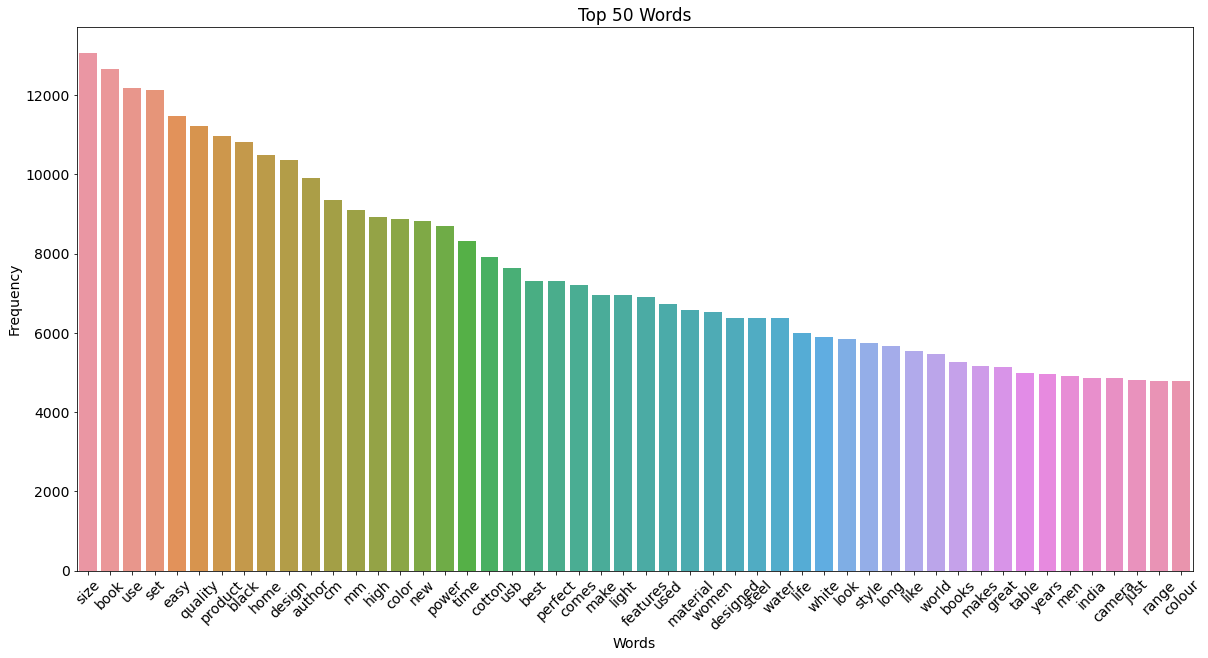

In [10]:
# Plot a bar chart for the top 50 most frequently occuring words
fig = plt.figure(figsize=(20,10))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_50,
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 50 Words', fontsize=17)

plt.show()

## Model Development

We plan to use supervised LSTM model for classification of the 4 product categories.
Therefore we need to reserve some of the data for out-of-sample testing. We will hold out 20% for test. We will encode the cleaned text from the product descriptions as sequences of GloVe vectors (300 floats for each word).

We are using GloVe pre-trained word vectors from this website: https://nlp.stanford.edu/projects/glove/

Reference: Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014.

GloVe: Global Vectors for Word Representation. https://nlp.stanford.edu/pubs/glove.pdf

The GloVe vectors are trained on a large corpus of text, in such a way that word with similar meaning have similar directions in the vector space.

We will be matching all the words in our product descriptions with a dictionary of the Glove vectors and so converting a sequence of words into a sequence of these vectors. Words not in the dictionary will be dropped but most commonly used words should be found. The dictionary we are using has a 400k vocabulary. To build an LSTM model we need all the word sequences to be of a uniform length. Therefore we will be truncating or padding all the word sequences to a uniform length of 150 tokens.

In [11]:
## encoding product_category as integers
labelEncoder = LabelEncoder()
label = labelEncoder.fit_transform(df['product_category'])
df['label'] = label

## Here we are reserving 20 % of the data for testing
train_valid, test = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

## here we are reserving 20 % of training data for validation
train, valid = train_test_split(train_valid, train_size=0.80, shuffle=True, random_state=42)

print((train.shape,valid.shape))

((32268, 5), (8067, 5))


In [12]:
## Function to Load the GloVe dictionary of word embeddings.
## Using GloVe pre-trained word vectors from this website: https://nlp.stanford.edu/projects/glove/
## 
## Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. 
## GloVe: Global Vectors for Word Representation. https://nlp.stanford.edu/pubs/glove.pdf
##
## This particular set of word vectors is described as:
## 
## Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download):

def get_glove_vectors(filename="data/glove.6B.100d.txt"):
    ## function from 
    ## https://campus.datacamp.com/courses/recurrent-neural-networks-for-language-modeling-in-python/rnn-architecture?ex=7
    # Get all word vectors from pre-trained model
    glove_vector_dict = {}
    with open(filename, encoding="UTF-8") as f:
        i = 0;
        for line in f:
            i = i + 1
            values = line.split()
            try:
                word = values[0]
                coefs = values[1:]
                glove_vector_dict[word] = np.asarray(coefs, dtype='float32')
            except Exception as inst:
                print(f'error on line {i} {type(inst)}')
                print(line)
    return glove_vector_dict

import time
start = time.time()

glove_vector_dict = get_glove_vectors()

end = time.time()
print(f'elapsed seconds = {end - start}')
type(glove_vector_dict)


elapsed seconds = 10.538125038146973


dict

In [13]:
def glove_word_embeddings(documents, pad_to=150):
    ## We plan to replace all the words in the documents
    ## with embeddings from the GloVe dictionary, skipping
    ## any words not found, and also padding the sequence 
    ## of embeddings to a fixed length.
    
    ## If none of the words match for a given document we will substitute
    ## a with place holder vector of one word, "neutral".
    d = glove_vector_dict
    neutral = d["neutral"]
    placeHolder = np.array([neutral])
    padNeutral = pad_sequences(placeHolder.T, pad_to, dtype='float32')
    outer = []
    for doc in documents:
        enc_list = []
        for word in doc.split(' '):
            if(type(d.get(word)) is np.ndarray):
                enc_list.append(d.get(word))
        if(len(enc_list) > 0):
            enc_array = np.array(enc_list)
            pad = pad_sequences(enc_array.T, pad_to, dtype='float32')
            outer.append(pad.T)
        else:
            outer.append(padNeutral.T)
    return np.array(outer)

In [14]:
train

,product_category,raw_text,cleaned_text,word_counts,label
33665,Clothing & Accessories,SportSoul Vinyl Dumbbell (Pair) A must have fo...,sportsoul vinyl dumbbell pair home workout fit...,36,1
4738,Household,Seven Horses Corner Round Bevelled Wall Mirror...,seven horses corner round bevelled wall mirror...,62,3
3624,Household,Candlesticks Baby Girls Holiday Skegging Cat,candlesticks baby girls holiday skegging cat,6,3
4270,Household,Swaha 30 Minutes Ghee Diya (12 cm x 10 cm x 5 ...,swaha minutes ghee diya cm cm cm set yellow sw...,73,3
38770,Clothing & Accessories,Muta Fashions Swim Wear for Women Georgette Sw...,muta fashions swim wear women georgette swim w...,154,1
...,...,...,...,...,...
43195,Electronics,ElecStars Kids LED Night Projector Lamp Making...,elecstars kids led night projector lamp making...,63,2
9198,Household,"Skittles Bite-Size Fruit Candies Tube, Origina...",skittles bite-size fruit candies tube original...,94,3
47061,Electronics,Fujifilm Instax Hello Kitty Instant Film Camer...,fujifilm instax hello kitty instant film camer...,52,2
3704,Household,"Hosley Apple Cinnamon Highly Fragranced, 2.65 ...",hosley apple cinnamon highly fragranced oz wax...,47,3


In [15]:
%%time

X_train = glove_word_embeddings(train['cleaned_text'])
display(X_train.shape)

y_train = np.array(train['label'])
display(y_train.shape)

X_valid = glove_word_embeddings(valid['cleaned_text'])
y_valid = np.array(valid['label'])
print(X_valid.shape)
print(y_valid.shape)

(32268, 150, 100)

(32268,)

(8067, 150, 100)
(8067,)
CPU times: total: 13.9 s
Wall time: 13.9 s


In [21]:
%%time

X_test = glove_word_embeddings(test['cleaned_text'])
y_test = np.array(test['label'])
print(X_test.shape)
print(y_test.shape)

(10084, 150, 100)
(10084,)
CPU times: total: 2.91 s
Wall time: 2.91 s


# Model 1 -- Single Layer LSTM, 128 units per layer

In [16]:
DROPOUT = 0.2
UNITS_PER_LAYER = 128

## Try switching to a Bidirectional LSTM model, as in this example
## https://keras.io/examples/nlp/bidirectional_lstm_imdb/

from tensorflow import keras
from tensorflow.keras import layers

model = Sequential()
model.add(LSTM(units=UNITS_PER_LAYER, input_shape=(150, 100), return_sequences=False, dropout=DROPOUT))
model.add(Dense(4, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

file_name = 'weights_{epoch:03d}_{val_accuracy:.4f}.hdf5'

checkpoint_filepath = os.path.join('.', 'SAVE_MODELS', file_name)

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 117,764
Trainable params: 117,764
Non-trainable params: 0
_________________________________________________________________


In [17]:
# history = model.fit(X_train, y_train, 
#                     batch_size=10, 
#                     epochs=100, 
#                     validation_data=(X_valid, y_valid),
#                     callbacks=[earlyStopping,modelCheckpoint]
#                    )

In [18]:
history = model.fit(X_train, y_train, 
                    batch_size=50, 
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlyStopping,modelCheckpoint]
                   )

Epoch 1/100
646/646 [==============================] - 94s 143ms/step - loss: 0.4322 - accuracy: 0.8675 - val_loss: 0.2959 - val_accuracy: 0.9200
Epoch 2/100
646/646 [==============================] - 98s 151ms/step - loss: 0.2838 - accuracy: 0.9219 - val_loss: 0.2599 - val_accuracy: 0.9249
Epoch 3/100
646/646 [==============================] - 96s 149ms/step - loss: 0.2587 - accuracy: 0.9278 - val_loss: 0.2470 - val_accuracy: 0.9305
Epoch 4/100
646/646 [==============================] - 100s 155ms/step - loss: 0.2531 - accuracy: 0.9271 - val_loss: 0.2418 - val_accuracy: 0.9275
Epoch 5/100
646/646 [==============================] - 97s 150ms/step - loss: 0.2280 - accuracy: 0.9363 - val_loss: 0.2265 - val_accuracy: 0.9349
Epoch 6/100
646/646 [==============================] - 96s 149ms/step - loss: 0.2169 - accuracy: 0.9384 - val_loss: 0.2192 - val_accuracy: 0.9376
Epoch 7/100
646/646 [==============================] - 96s 148ms/step - loss: 0.2044 - accuracy: 0.9407 - val_loss: 0.2053 

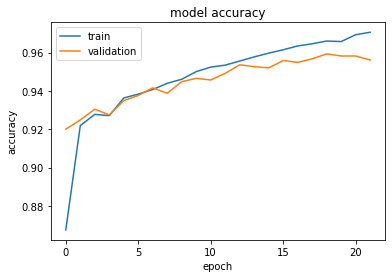

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
labelEncoder = LabelEncoder()
label = labelEncoder.fit_transform(df['product_category'])

predict_proba = model.predict(X_test,batch_size=20)
predict_index = np.argmax(predict_proba, axis=1)
predicted = labelEncoder.inverse_transform(predict_index)
print(predicted[:10])

505/505 [==============================] - 19s 39ms/step
['Books' 'Clothing & Accessories' 'Electronics' 'Household' 'Household'
 'Books' 'Clothing & Accessories' 'Household' 'Clothing & Accessories'
 'Books']


In [30]:
test['predicted'] = predicted

In [35]:
accuracy = (test['product_category']==test['predicted']).sum()/len(test)
print(f'Model Test Accuracy = {accuracy:.4f}')

Model Test Accuracy = 0.9595


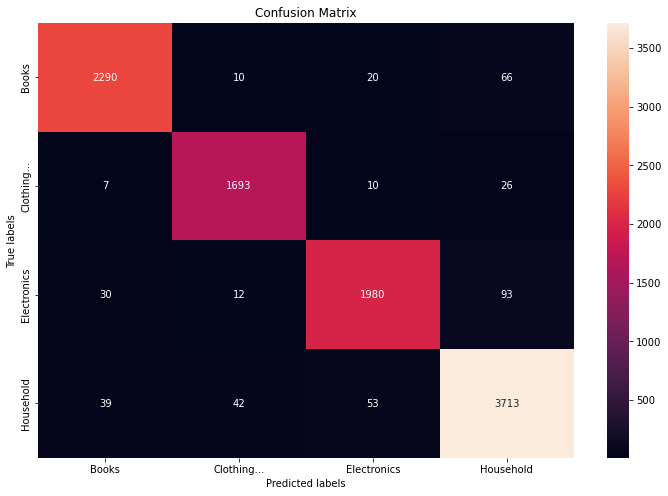

In [36]:
# display confusion matrix here 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
label_names = ['Books','Clothing...','Electronics','Household']
cm = confusion_matrix(test['product_category'], test['predicted'])
fig = plt.figure(figsize=(12,8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_names); 
ax.yaxis.set_ticklabels(label_names);